# Chapter 5, Exercise 2: Let's Make The Classifier Better

Chapter 5 introduced the pet classifer. Exercise 2 is to make it better.  I'm going to try a few things to see if I can do that.

First up: trying the [Wide Residual Network](https://github.com/szagoruyko/wide-residual-networks).  The original paper is [here](https://arxiv.org/abs/1605.07146).

> For example, we demonstrate that even a simple 16-layer-deep wide residual network outperforms in accuracy and efficiency all previous deep residual networks, including thousand-layer-deep networks. We further show that WRNs achieve incredibly good results (e.g., achieving new state-of-the-art results on CIFAR-10, CIFAR-100, SVHN, COCO and substantial improvements on ImageNet) and train several times faster than pre-activation ResNets.

I found this on FastAI...but [it was for version 1](https://fastai1.fast.ai/vision.models.html#wrn_22).  Fortunately, PyTorch has a model for this: https://pytorch.org/hub/pytorch_vision_wide_resnet/.

Let's start with the usual boilerplate:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # The answer to Life, the Universe, and Everything

Now we get fastai & the Pets data set:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

We'll create our DataBlock:

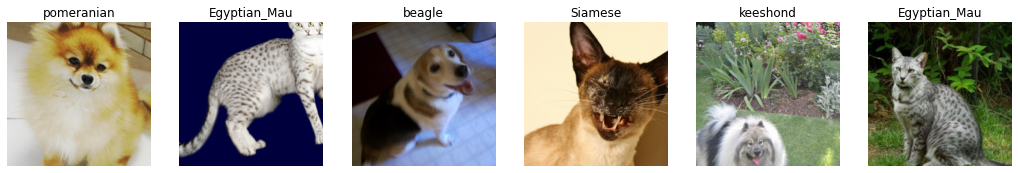

In [5]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)    
)

dls = pets.dataloaders(path/"images")
dls.show_batch(nrows=1, ncols=6)

In [6]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/Abyssinian_62.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x335
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/oxford-iiit-pet/images/Abyssinian_62.jpg
    applying partial gives
      Abyssinian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=500x335, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch

Now let's see if we can create our model.

In [8]:
wrn_50 = torch.hub.load('pytorch/vision:v0.6.0', 'wide_resnet50_2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Let's see if we can do the [PyTorch example code first](https://pytorch.org/hub/pytorch_vision_wide_resnet/):

In [11]:
dls??

In [14]:
from PIL import Image
from torchvision import transforms

input_image = Image.open('/storage/data/oxford-iiit-pet/images/Abyssinian_62.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # Create a mini-batch as expected by the model

# See if we can move to GPU
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([-0.8545, -0.1512, -0.4708, -0.8874, -0.6908, -0.1116, -0.8377,  0.5822,
         0.1723, -0.3191, -0.8148, -0.8687, -0.2653, -0.7437, -0.9214, -0.5788,
        -0.5217, -0.3436, -0.1769, -0.4362, -0.8506, -0.8992, -0.9836, -0.1449,
        -0.7812, -0.7526, -0.8717, -0.5669, -0.4492, -0.3335, -0.6582, -0.8192,
        -0.4923, -0.5792, -0.1275, -0.7476,  0.5288, -0.3254, -0.5522,  0.2526,
        -0.5217, -0.4070, -0.7762, -0.1381, -0.2573, -0.2172, -0.7415, -0.4907,
        -0.7082, -0.7914, -0.6391,  0.4547, -0.0716, -0.2449, -0.2365, -0.9654,
        -0.5666, -1.0117, -0.5660,  0.0302,  0.6279, -0.0199, -0.1214, -0.0927,
        -0.4243, -0.4321, -0.3702, -0.2981, -0.8466, -0.2599, -1.0865,  0.2668,
        -1.0992, -0.3873, -0.9975, -0.6282,  0.1469, -0.4731,  0.3691,  0.2299,
        -0.6980, -1.2485, -0.0710, -0.5790, -0.3129, -0.0829,  0.0264,  0.5627,
         0.1255, -0.3092, -0.4199, -0.6270, -1.2795, -0.0394,  0.0918, -1.4058,
         0.0088, -0.6706, -0.8978, -0.52

This now brings up the question of how to get the _label_.  THis is surprisingly unclear.  [This post](https://discuss.pytorch.org/t/imagenet-classes/4923) appears to have the best current solutions; despite what I see in https://github.com/pytorch/vision/issues/713, there doesn't seem to be an easy official way to do this short of [downloading the whole frickin' data set](https://pytorch.org/docs/stable/torchvision/datasets.html#imagenet).

In [16]:
!curl -O https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30564  100 30564    0     0  97257      0 --:--:-- --:--:-- --:--:-- 97337


In [18]:
!head imagenet1000_clsidx_to_labels.txt

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',


In [27]:
torch.topk(torch.nn.functional.softmax(output[0], dim=0),
           10)

torch.return_types.topk(
values=tensor([0.0048, 0.0046, 0.0043, 0.0043, 0.0037, 0.0034, 0.0032, 0.0032, 0.0032,
        0.0032], device='cuda:0'),
indices=tensor([600, 463, 852, 731, 515, 898, 733, 837, 447, 412], device='cuda:0'))

In [ ]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())


# TODO

- Sort out top predictions & labels
- See if that prediction makes any sense...if I'm reading things right, that output list is "hook", "bucket", "tennis ball"
- try retraining this using fastai and its learn API.  This was giving me weird errors ehwn I tried `learn = cnn_learner(dns, fastnet_model)`

In [ ]:
s